In [1]:
import os
import sys

os.chdir('..')

In [2]:
import torch
from src.tacogfn.tasks import pharmaco_frag

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_state = torch.load('logs/20240121-crossdocked-mo-256-pocket_graph/model_state_29000.pt')
config = dict(model_state['cfg'])

trail = pharmaco_frag.PharmacophoreTrainer(config)
trail.model.load_state_dict(model_state['models_state_dict'][0])
trail.model.eval()

loaded 15016 ids for train
loaded 100 ids for test
loaded 15207 ids for train
loaded 100 ids for test


Hyperparameters:

log_dir: ./logs/20240121-crossdocked-mo-256-pocket_graph
logger: wandb
device: cuda
split_file: dataset/split_by_name.pt
pharmaco_db: misc/pharmacophores_db.lmdb
pocket_db: misc/pocket_db.lmdb
dock_pharmaco: dataset/affinity_prediction_pharmacophores/crossdocked_dim_256
dock_proxy: model_weights/crossdocked_dim_256.pth
avg_score: dataset/pocket_to_avg_zinc_vina_score.pt
info_only_dock_proxy: model_weights/zinc_1000_dim_128.pth
info_only_dock_pharmaco: dataset/affinity_prediction_pharmacophores/zinc_1000_dim_128
seed: 0
validate_every: 1000
checkpoint_every: null
print_every: 100
start_at_step: 0
num_final_gen_steps: null
num_training_steps: 50000
num_workers: 8
hostname: d26630badf49
pickle_mp_messages: false
git_hash: a16763c
overwrite_existing_exp: true
algo:
  method: TB
  global_batch_size: 16
  max_len: 128
  max_nodes: 9
  max_edges: 128
  illegal_action_logre

PocketConditionalGraphTransformerGFN(
  (transf): PocketConditionalGraphTransformer(
    (pocket_encoder): GVP_embedding(
      (W_s): Embedding(20, 20)
      (W_v): Sequential(
        (0): LayerNorm(
          (scalar_norm): LayerNorm((26,), eps=1e-05, elementwise_affine=True)
        )
        (1): GVP(
          (wh): Linear(in_features=3, out_features=16, bias=False)
          (ws): Linear(in_features=42, out_features=128, bias=True)
          (wv): Linear(in_features=16, out_features=16, bias=False)
        )
      )
      (W_e): Sequential(
        (0): LayerNorm(
          (scalar_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): GVP(
          (wh): Linear(in_features=1, out_features=1, bias=False)
          (ws): Linear(in_features=33, out_features=32, bias=True)
          (wv): Linear(in_features=1, out_features=1, bias=False)
        )
      )
      (layers): ModuleList(
        (0): GVPConvLayer(
          (conv): GVPConv()
          (norm)

In [4]:
n = 1000
temp = 1.0

pharmacophore_idxs = [99] * n

In [5]:
temperatures = (
    torch.rand(n) * trail.cfg.cond.temperature.dist_params[1] 
    # + torch.ones(n) * self.cfg.cond.temperature.dist_params[1] * 3 / 4
)  # default to sampling from the upper 3/4 of the temperature range

cond_info = {
    "encoding": trail.task.temperature_conditional.encode(temperatures),
    "pharmacophore": torch.as_tensor(pharmacophore_idxs),
}

with torch.no_grad():
    trail.algo.graph_sampler.sample_temp = temp
    trajs = trail.algo.graph_sampler.sample_from_model(
        trail.model,
        n, 
        cond_info,
        'cpu')
    trail.algo.graph_sampler.sample_temp = 1.0
    
mols = [trail.ctx.graph_to_mol(traj["result"]) for traj in trajs]

In [13]:
import torch
!pwd

/home/tsa87/refactor-tacogfn


In [4]:
trajs = torch.load('random_trajs.pt')

In [19]:
from rdkit import Chem

In [ ]:
# for each fragment edge
    # for each of the directions
        # a <= fragment 1
        # b <= fragment 2 
        # we connect b to all its own edges expect one that is connected to a 
        # we check b's atom

In [40]:
for edge in graph.edges(data=True):
    print(edge)
    print

(0, 1, {'src_attach': 1, 'dst_attach': 0})
(0, 2, {'dst_attach': 0, 'src_attach': 5})
(0, 3, {'dst_attach': 0, 'src_attach': 4})
(0, 4, {'src_attach': 0, 'dst_attach': 0})
(0, 7, {'dst_attach': 0, 'src_attach': 2})
(4, 5, {'dst_attach': 3, 'src_attach': 3})
(5, 6, {'src_attach': 4, 'dst_attach': 0})
(5, 8, {'src_attach': 1, 'dst_attach': 2})


In [43]:
graph.nodes[source_i]['v']

65

In [46]:
attachment['src_attach']

1

In [ ]:
65, 1, SP2-C

In [42]:
graph = trajs[0]['result']

# iteratre ovee the edges

for edge in graph.edges(data=True):
    example_edge = edge
    break

source_i, dest_i, attachment = example_edge

# dest_mol = Chem.EditableMol()
# for k, v in graph[dest_i].items():
#     if k != source_i:
#         # add a single bond to a new carbon
#         dest_mol.AddAtom(Chem.Atom(6))
#         dest_mol.AddBond(v['dst_attach'], len(dest_mol.GetAtoms()) - 1, Chem.BondType.SINGLE)   

dest_mol = trail.ctx.frags_mol[graph.nodes[dest_i]['v']]

for atom in dest_mol.GetAtoms():
    atom.SetProp('molAtomMapNumber', str(atom.GetIdx()))

for atomObj in dest_mol.GetAtoms():
    if atomObj.GetProp('molAtomMapNumber') == str(trail.ctx.frags_stems[graph.nodes[dest_i]['v']][attachment['dst_attach']]):
        print(str(atomObj.GetHybridization()), atomObj.GetSymbol())
        
        # source_i is what type
    

SP2 C


In [17]:
fragments[graph.nodes[dest_i]['v']]

NameError: name 'fragments' is not defined

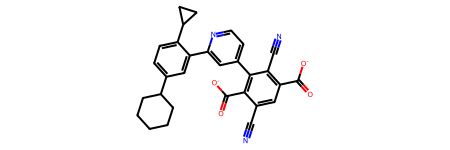

In [6]:
trail.ctx.graph_to_mol(trajs[0]['result'])